<a href="https://colab.research.google.com/github/gibsonx/tf_skeleton/blob/master/tf_keypoint_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!git clone https://github.com/gibsonx/tf_skeleton.git

fatal: destination path 'tf_skeleton' already exists and is not an empty directory.


In [3]:
!pip install -r /content/tf_skeleton/requirements.txt > /dev/null

In [4]:
from pycocotools.coco import COCO
import numpy as np
import os.path
from typing import Any, Callable, List, Optional, Tuple
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os, json, cv2, numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

from keras.models import Sequential

from keras.layers import (
    Flatten,
    Dense,
    Dropout,
    Conv2D,
    LeakyReLU,
    BatchNormalization,
    MaxPool2D,
)

In [5]:
img_dir="/content/drive/MyDrive/Dataset/aspine202030604/images"
annotations_file="/content/drive/MyDrive/Dataset/aspine202030604/annotations/person_keypoints_Train.json"

In [6]:
coco=COCO(annotations_file)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [7]:
#validation set details
imgIds = coco.getImgIds()
print("Total images: {}".format(len(imgIds)))
rand=np.random.randint(0,len(imgIds))
img = coco.loadImgs(imgIds[rand])[0]
print("Image example:")
print(img)
annIds=coco.getAnnIds()
print("\nTotal annotations: {}".format(len(annIds)))
ann=coco.loadAnns(coco.getAnnIds(imgIds=img['id']))
print("Annotation example:")
print(ann)

Total images: 188
Image example:
{'id': 38, 'width': 1184, 'height': 2112, 'file_name': 'img-00037-00001.jpg', 'license': 0, 'flickr_url': '', 'coco_url': '', 'date_captured': 0}

Total annotations: 188
Annotation example:
[{'id': 10, 'image_id': 38, 'category_id': 1, 'segmentation': [], 'area': 463408.63680000004, 'bbox': [158.3, 1443.46, 801.44, 578.22], 'iscrowd': 0, 'attributes': {'occluded': False}, 'keypoints': [275.56, 1472.0, 2, 780.78, 1443.46, 2, 158.3, 1652.89, 2, 959.74, 1607.86, 2, 479.14, 1611.5, 2, 615.35, 1602.45, 2, 372.95, 1582.93, 2, 696.52, 1548.32, 2, 549.7, 1602.44, 2, 315.5, 1823.25, 2, 805.05, 1800.22, 2, 427.88, 2021.68, 2, 698.75, 1989.06, 2, 456.79, 1467.34, 2, 558.59, 1448.63, 2, 523.87, 1477.34, 2], 'num_keypoints': 16}]


In [8]:
keypoints_original = [[list(a) for a in zip(*[iter(ann[0]['keypoints'])]*3)]]

def CoupeToInt(coupe: List[float]) -> List[int]:
    return list(map(int, coupe))

converted_keypoints = [ CoupeToInt(el[0:2]) for kp in keypoints_original for el in kp ]


kps_metrix = []
image_list = []

for id in imgIds:
    img = coco.loadImgs(id)[0]
    imgPath = os.path.join(img_dir,img['file_name'])
    image_list.append(Image.open(imgPath))

    # load annotations
    ann=coco.loadAnns(coco.getAnnIds(imgIds=img['id']))
    keypoints_original = [[list(a) for a in zip(*[iter(ann[0]['keypoints'])]*3)]]
    kps_row = []
    for kp in keypoints_original:
        for el in kp:
            kps_row.extend(el[0:2])

    kps_metrix.append(kps_row)

df = pd.DataFrame(kps_metrix)

image_array_list = [np.array(img) for img in image_list]
df['image'] = image_array_list

df.head

<bound method NDFrame.head of           0        1       2        3       4        5       6        7  \
0    352.81  1459.45  851.58  1465.83  223.64  1579.30  971.79  1574.86   
1    376.07  1452.89  827.69  1464.03  265.82  1544.70  923.04  1553.75   
2    343.41  1538.83  715.60  1556.86  189.53  1659.92  866.44  1676.36   
3    383.17  1488.92  791.44  1458.09  250.53  1613.92  963.98  1601.94   
4    361.01  1529.92  834.01  1534.78  253.08  1641.25  919.97  1621.81   
..      ...      ...     ...      ...     ...      ...     ...      ...   
183  415.00  1554.04  832.54  1556.31  286.62  1658.62  930.63  1658.42   
184  379.95  1530.97  837.97  1536.60  256.25  1638.93  933.16  1653.11   
185  427.51  1484.52  787.75  1490.56  286.64  1600.76  913.99  1602.96   
186  376.74  1442.40  843.52  1466.95  224.89  1552.12  974.78  1559.49   
187  374.46  1472.39  853.56  1473.90  287.34  1573.99  937.54  1596.52   

          8        9  ...       23      24       25      26       27 

In [9]:
#df.to_csv('out\df.csv')

In [10]:
keypoints_classes_ids2names = {0: '1', 1: '2', 2: '3', 3: '4', 4: '5', 5: '6', 6: '7', 7: '8', 8: '9', 9: '10', 10: '11', 11: '12', 12: '13', 13: '14', 14: '15', 15: '16'}

def visualize(p, keypoints):

    image = mpimg.imread(p)

    # for kps in keypoints:
    for idx, kp in enumerate(keypoints):
        image = cv2.putText(image.copy(), "" + keypoints_classes_ids2names[idx], tuple(kp), cv2.FONT_HERSHEY_PLAIN, 2, (32,253,0), 3, cv2.LINE_AA)
        image = cv2.circle(image.copy(), tuple(kp), 5, (255,0,0), 10)

        # for kps in keypoints:
        #     for idx, kp in enumerate(kps):
        #         image = cv2.circle(image_original, tuple(kp), 5, (255,0,0), 10)
        #         image = cv2.putText(image_original, " " + keypoints_classes_ids2names[idx], tuple(kp), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,0,0), 3, cv2.LINE_AA)

    plt.figure(figsize=(25,25))
    plt.imshow(image)
    plt.show()


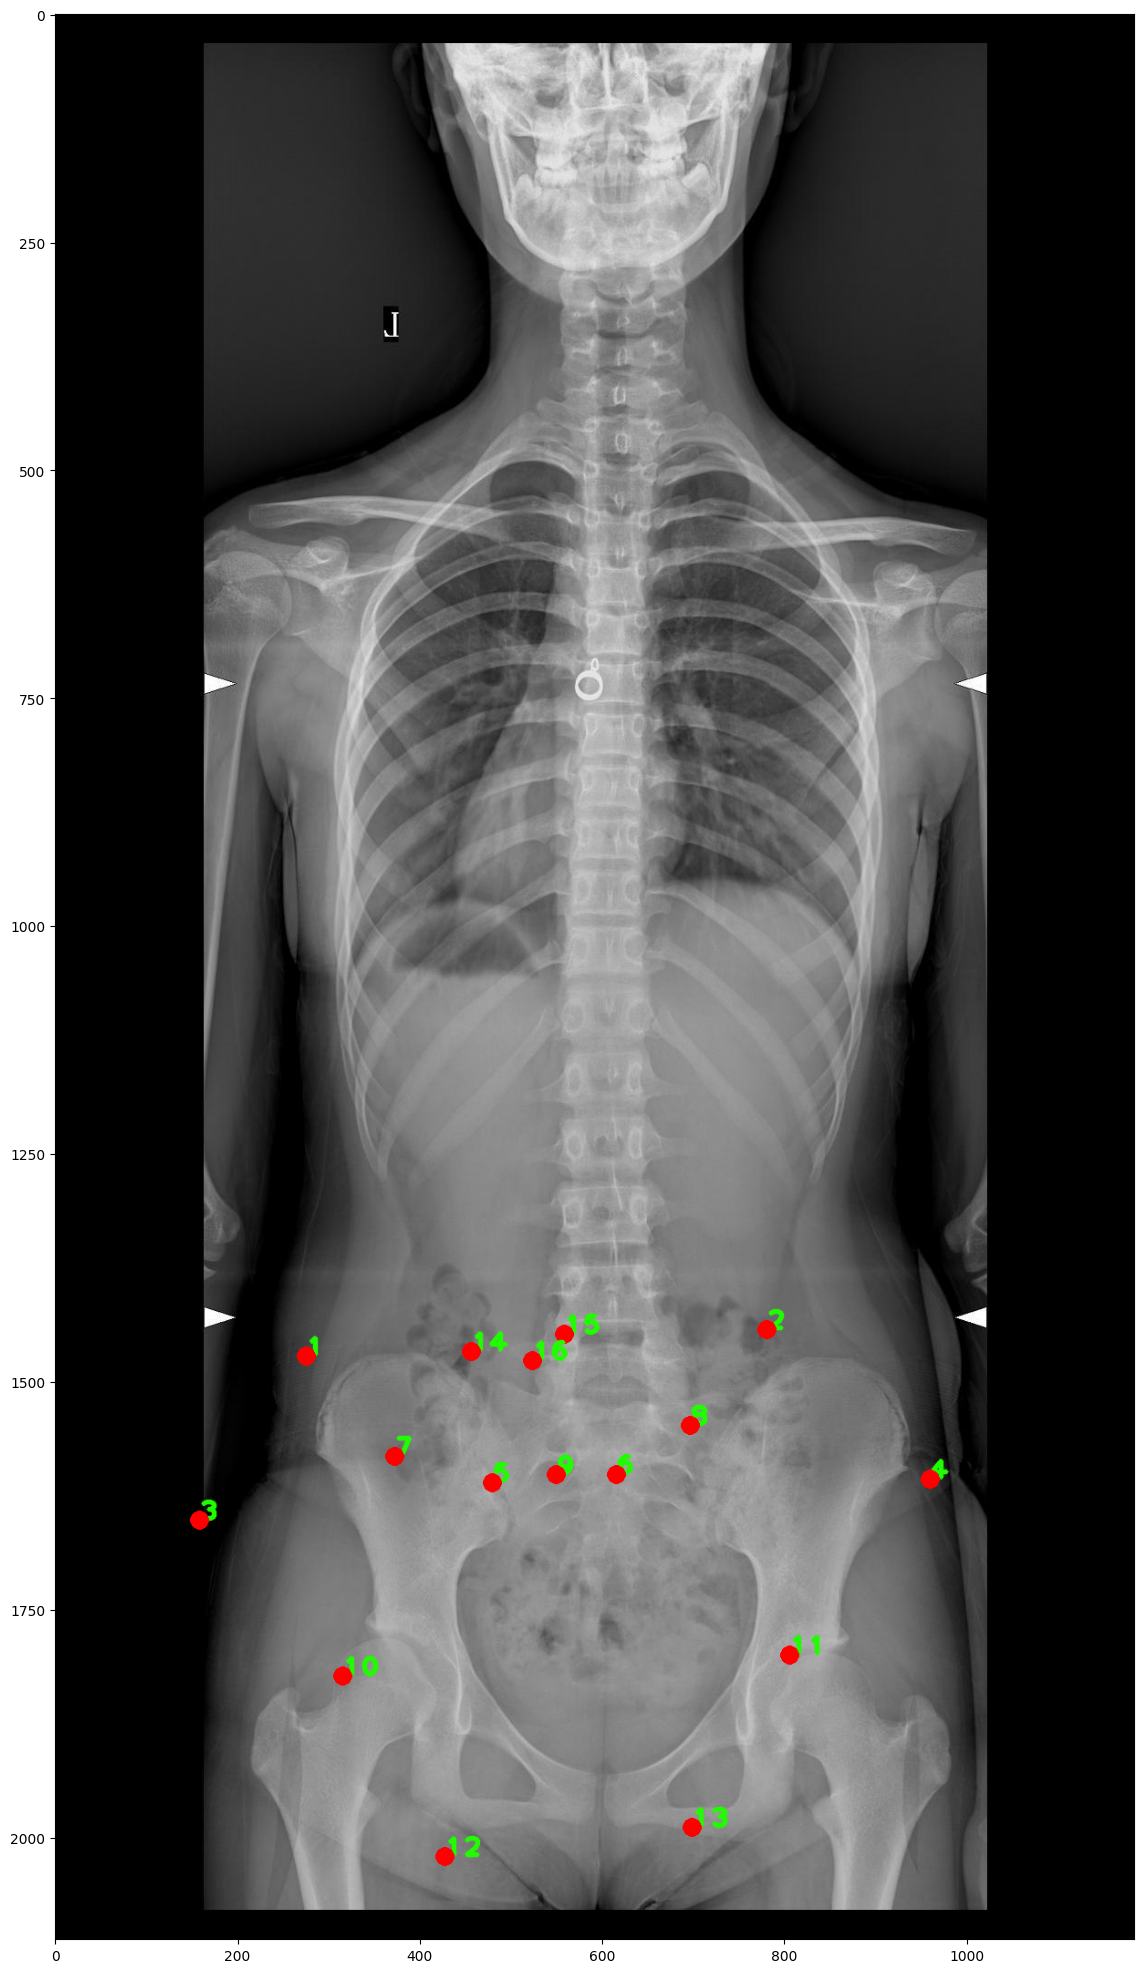

In [11]:
imgPath = os.path.join(img_dir,img['file_name'])
visualize(imgPath,converted_keypoints)

In [ ]:
# Building a CNN model using Sequential API
model = Sequential([
    Conv2D(1, (5, 5), padding='same', use_bias=False, input_shape=(2112, 1184, 3)),
    LeakyReLU(alpha=0.1),
    BatchNormalization(),
    MaxPool2D(pool_size=(2, 2)),

    # Conv2D(32, (4, 4), padding='same', use_bias=False),
    # LeakyReLU(alpha=0.1),
    # BatchNormalization(),
    # MaxPool2D(pool_size=(2, 2)),

    # Conv2D(64, (3, 3), padding='same', use_bias=False),
    # LeakyReLU(alpha=0.1),
    # BatchNormalization(),
    # MaxPool2D(pool_size=(2, 2)),

    # Conv2D(128, (2, 2), padding='same', use_bias=False),
    # LeakyReLU(alpha=0.1),
    # BatchNormalization(),
    # MaxPool2D(pool_size=(2, 2)),

    Flatten(),
    Dense(1024, activation='relu'),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(32)
])

In [ ]:
model.summary()

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
# initializing few hyper parameters
epochs = 200
batch_size = 128
validation_split = 0.2

In [ ]:

y_train=df.loc[:, df.columns != 'image']

In [ ]:
x_train=np.stack(df['image'])

In [ ]:
x_train=np.stack(df['image'])

In [ ]:
model.compile(optimizer='adam',loss='mean_squared_error',metrics=['accuracy'])
history=model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_split = validation_split)